## Import libraries


In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, sampler
from torchvision.datasets import ImageFolder
from transformers import ViTForImageClassification, ViTImageProcessor

/opt/homebrew/Caskroom/miniforge/base/envs/PBL/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dataset


In [3]:
MODEL_NAME = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(MODEL_NAME, local_files_only=True)

In [4]:
def load_dataset(
    root: str,
    test: bool,
    batch_size: int = 16,
    shuffle: bool = True,
    valid_size: float = 0.4,
    num_workers: int = 4,
):
    if not test:
        data_augmentation = transforms.Compose(
            [
                transforms.RandomRotation(degrees=15),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomResizedCrop(size=(224, 224), antialias=True),
                transforms.ColorJitter(
                    brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1
                ),
            ]
        )
        transform = transforms.Compose(
            [
                data_augmentation,
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=processor.image_mean, std=processor.image_std
                ),
            ]
        )
        dataset = ImageFolder(os.path.join(root, "train"), transform=transform)
        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
        )

    transform = transforms.Compose(
        [
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
        ]
    )
    dataset = ImageFolder(os.path.join(root, "test"), transform=transform)
    num_test = len(dataset)
    indices = list(range(num_test))
    split = int(np.floor(valid_size * num_test))

    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)

    test_idx, valid_idx = indices[split:], indices[:split]
    test_sampler = sampler.SubsetRandomSampler(test_idx)
    valid_sampler = sampler.SubsetRandomSampler(valid_idx)

    test_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=test_sampler,
        num_workers=num_workers,
    )
    valid_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
    )
    return test_loader, valid_loader

## Model


In [5]:
def load_model(model_name: str, num_classes: int):
    model = ViTForImageClassification.from_pretrained(model_name, local_files_only=True)
    model.classifier = nn.Sequential(
        nn.Linear(in_features=768, out_features=512),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=512, out_features=256),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features=256, out_features=num_classes),
    )
    return model

## Train


In [6]:
train_loader = load_dataset(root="", test=False, batch_size=32)
test_loader, valid_loader = load_dataset(
    root="", test=True, batch_size=32, valid_size=0.3
)

In [7]:
model = load_model(model_name=MODEL_NAME, num_classes=10)
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
NUM_EPOCHS = 15
losses, accuracies = [], []
for epoch in range(NUM_EPOCHS):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training", colour="green"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    losses.append(running_loss)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc="Validation", colour="yellow"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracies.append(100 * correct / total)
    print(
        f"- Epoch [{epoch + 1:2}/{NUM_EPOCHS}], Loss: {losses[-1]:.4f}, Accuracy: {accuracies[-1]:.2f}%"
    )
    scheduler.step()

    # Save checkpoint
    if (epoch + 1) % 5 == 0:
        torch.save(
            {
                "model_state_dict": model.state_dict(),
            },
            f"checkpoint_{epoch + 1}.pt",
        )

Validation: 100%|██████████| 4/4 [00:29<00:00,  7.45s/it]


- Epoch [ 1/20], Loss: 26.6443, Accuracy: 68.33%


Validation: 100%|██████████| 4/4 [00:31<00:00,  7.84s/it]


- Epoch [ 2/20], Loss: 17.6692, Accuracy: 84.17%


Validation: 100%|██████████| 4/4 [00:31<00:00,  7.75s/it]


- Epoch [ 3/20], Loss: 9.4656, Accuracy: 90.83%


Validation: 100%|██████████| 4/4 [00:30<00:00,  7.74s/it]


- Epoch [ 4/20], Loss: 5.3433, Accuracy: 97.50%


Validation: 100%|██████████| 4/4 [00:30<00:00,  7.68s/it]


- Epoch [ 5/20], Loss: 2.3774, Accuracy: 97.50%


Validation: 100%|██████████| 4/4 [00:31<00:00,  7.84s/it]


- Epoch [ 6/20], Loss: 1.5619, Accuracy: 97.50%


Validation: 100%|██████████| 4/4 [00:32<00:00,  8.12s/it]


- Epoch [ 7/20], Loss: 1.4391, Accuracy: 99.17%


Validation: 100%|██████████| 4/4 [00:32<00:00,  8.24s/it]


- Epoch [ 8/20], Loss: 1.2734, Accuracy: 99.17%


Validation: 100%|██████████| 4/4 [00:32<00:00,  8.05s/it]


- Epoch [ 9/20], Loss: 1.3822, Accuracy: 99.17%


Validation: 100%|██████████| 4/4 [00:32<00:00,  8.18s/it]


- Epoch [10/20], Loss: 0.9146, Accuracy: 99.17%


Validation: 100%|██████████| 4/4 [00:32<00:00,  8.02s/it]


- Epoch [11/20], Loss: 0.8872, Accuracy: 99.17%


Validation: 100%|██████████| 4/4 [00:31<00:00,  7.97s/it]


- Epoch [12/20], Loss: 0.8780, Accuracy: 99.17%


Validation: 100%|██████████| 4/4 [00:32<00:00,  8.24s/it]


- Epoch [13/20], Loss: 0.9954, Accuracy: 99.17%


Validation: 100%|██████████| 4/4 [00:31<00:00,  7.92s/it]


- Epoch [14/20], Loss: 0.9418, Accuracy: 99.17%


Validation: 100%|██████████| 4/4 [00:31<00:00,  7.92s/it]


- Epoch [15/20], Loss: 0.9836, Accuracy: 99.17%


Validation: 100%|██████████| 4/4 [00:31<00:00,  7.80s/it]


- Epoch [16/20], Loss: 0.7780, Accuracy: 99.17%


Validation: 100%|██████████| 4/4 [00:31<00:00,  7.81s/it]


- Epoch [17/20], Loss: 0.8154, Accuracy: 99.17%


Validation: 100%|██████████| 4/4 [00:31<00:00,  7.87s/it]


- Epoch [18/20], Loss: 1.0338, Accuracy: 99.17%


Validation: 100%|██████████| 4/4 [00:31<00:00,  7.79s/it]


- Epoch [19/20], Loss: 1.1306, Accuracy: 99.17%


Validation: 100%|██████████| 4/4 [00:31<00:00,  7.80s/it]


- Epoch [20/20], Loss: 0.9707, Accuracy: 99.17%


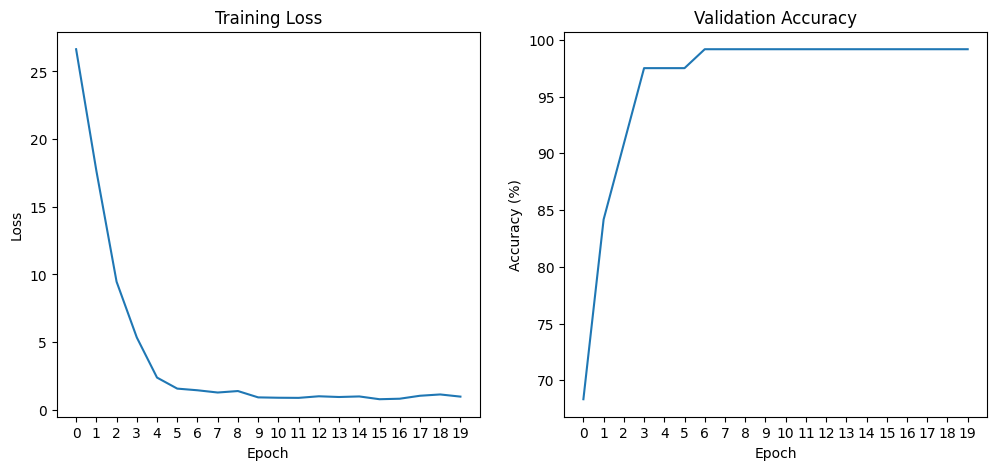

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xticks(np.arange(len(losses)))
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.xticks(np.arange(len(accuracies)))
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.show()

## Test model


In [11]:
def test_checkpoint(path: str, loader: DataLoader):
    checkpoint = torch.load(f=path, map_location=device, weights_only=True)
    model = load_model(model_name=MODEL_NAME, num_classes=10)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)

    model.eval()
    _correct, _total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing", colour="yellow"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            _total += labels.size(0)
            _correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * _correct / _total:.2f}%")

In [12]:
test_checkpoint("checkpoint_5.pt", test_loader)

Testing: 100%|██████████| 9/9 [00:41<00:00,  4.65s/it]

Test Accuracy: 95.71%


In [13]:
test_checkpoint("checkpoint_10.pt", test_loader)

Testing: 100%|██████████| 9/9 [00:41<00:00,  4.56s/it]

Test Accuracy: 98.21%


In [14]:
test_checkpoint("checkpoint_15.pt", test_loader)

Testing: 100%|██████████| 9/9 [00:40<00:00,  4.52s/it]

Test Accuracy: 98.21%
